Download the dataset: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>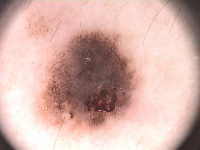</td><td>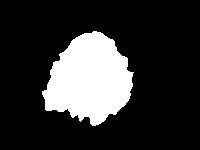</td></tr></table>


These are photos of two types of **skin lesions:** melanoma and moles.

In [ ]:
from skimage.io import imread
import os
import json
from tqdm.notebook import tqdm
from tqdm.autonotebook import tqdm, trange
from time import time
from tqdm import tqdm
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  """


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
! unrar x /content/gdrive/MyDrive/PH2Dataset.rar

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

The images have different sizes. Let's change their size to $256\times 256$ pixels.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [ ]:
len(lesions)

200

Let's draw some images.

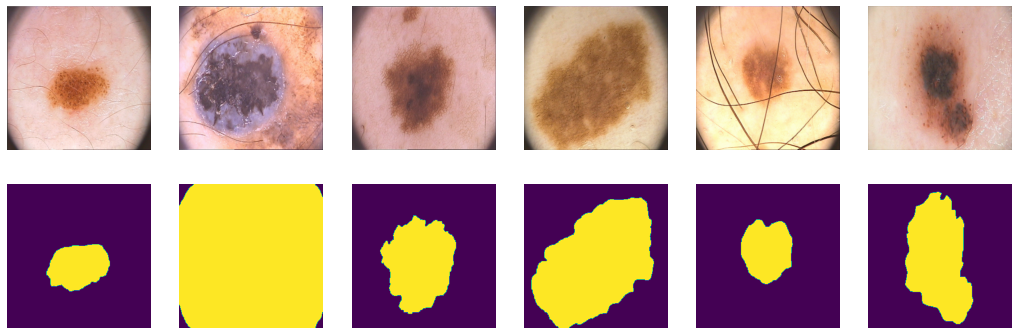

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Let's divide our 200 images into 100/50/50
for training, validation and test, respectively.

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

100 50 50


#### Augmentation

In [ ]:
import random
import torchvision
from albumentations import VerticalFlip, HorizontalFlip, RandomSizedCrop, Rotate,Compose,Resize,OneOf,RandomBrightness,RandomContrast,Normalize,HorizontalFlip,Blur,ElasticTransform,GridDistortion,OpticalDistortion,GaussNoise, RandomBrightnessContrast

def Augment(X, y):
    if random.random() > 0.5:
        X = torchvision.transforms.functional.vflip(X)
        y = torchvision.transforms.functional.vflip(y)

    r = random.random()
    degs = [-20, 20, -15, 15, -10, 10, -5, 5]
    if 0.05 <= r < 0.7:
        deg = random.choice(degs)
        X = torchvision.transforms.functional.rotate(X, deg)
        y = torchvision.transforms.functional.rotate(y, deg)

    return X, y

#### PyTorch DataLoader

In [ ]:
from torch.utils.data import DataLoader
batch_size = 25
data_tr = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

-----------------------------------------------------------------------------------------

# SegNet 

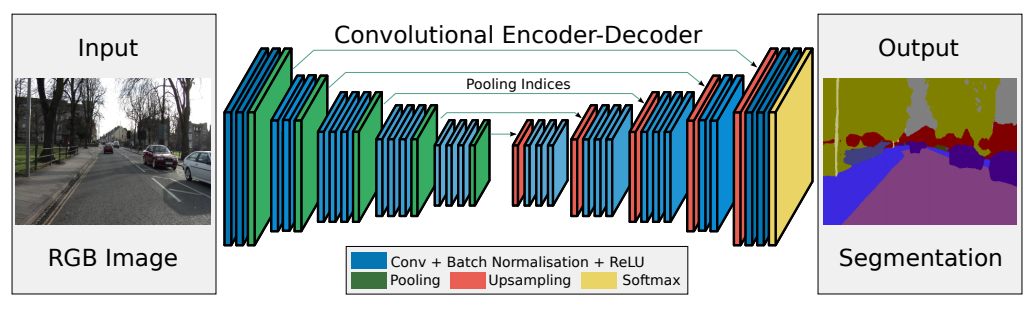



In [ ]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)   # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)  # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2)  # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):
        # encoder
        x = self.enc_conv0(x)
        e0, indices_0 = self.pool0(x)
        e0 = self.enc_conv1(e0)
        e1, indices_1 = self.pool1(e0)
        e1 = self.enc_conv2(e1)
        e2, indices_2 = self.pool2(e1)
        e2 = self.enc_conv3(e2)
        e3, indices_3 = self.pool3(e2)

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, indices_3))
        d1 = self.dec_conv1(self.upsample1(d0, indices_2))
        d2 = self.dec_conv2(self.upsample2(d1, indices_1))
        d3 = self.dec_conv3(self.upsample3(d2, indices_0))  # no activation
        return d3

## Metric

We will use the following metric to evaluate the quality:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$




![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)



![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [ ]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    outputs = outputs.squeeze(1).byte()
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))
    union = (outputs | labels).float().sum((1, 2))
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)
    
    thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10
    
    return thresholded

## Loss

A popular method for binary segmentation is *binary cross-entropy*, which is given as follows:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right],$$

where $y$ is the target of the desired result and $\hat y$ is the output of the model.

However, this loss suffers from numerical instability problems. The most important thing is that $\lim_{x\rightarrow0}\log(x)=\infty$ leads to instability in the optimization process. This function is equivalent to the first one and is not so subject to numerical instability:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

In [ ]:
def bce_loss(y_real, y_pred):
  
    loss = (torch.clamp(y_pred, min=0.) - y_pred*y_real + torch.log(1 + torch.exp(-torch.abs(y_pred))))

    return torch.mean(loss)

## Train

In [ ]:
def train(model, opt, scheduler, loss_fn, epochs, data_tr, data_val):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    X_val, Y_val = next(iter(data_val))
    history = []

    for epoch in range(epochs):
        scheduler.step()

        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        loss_train = 0
        train_acc = 0
        loss_val = 0
        acc_val = 0
        model.to(device)
        model.train()  # train mode

        for X_batch, Y_batch in tqdm(data_tr):
            X_batch, Y_batch = Augment(X_batch, Y_batch)
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)

            opt.zero_grad()

            Y_pred = model(X_batch)
            Y_pred = Y_pred

            loss = loss_fn(Y_batch, Y_pred)
            loss_train += loss.item()
            loss.backward()
            opt.step()

            train_acc += torch.mean(iou_pytorch(torch.round(torch.sigmoid(model(X_batch))), Y_batch)).detach().cpu().numpy().item()

            del X_batch, Y_batch, loss
            torch.cuda.empty_cache()  

        toc = time()
        print('loss = ', loss_train/len(data_tr))

        model.eval()
        X_val = X_val.to(device)
        Y_val = Y_val.to(device)

        Y_hat = torch.sigmoid(model(X_val)).detach()
        loss_val = loss_fn(Y_val, Y_hat).item()
        
        acc_val = torch.mean(iou_pytorch(torch.round(Y_hat), Y_val)).detach().cpu().numpy().item()

        if acc_val > best_acc:
            best_acc = acc_val
            best_model_wts = model.state_dict()

        history.append((loss_train/len(data_tr), train_acc/len(data_tr), loss_val, acc_val))

        X_val = X_val.to('cpu')
        Y_val = Y_val.to('cpu')
        Y_hat = Y_hat.to('cpu')

        # Visualize tools
        clear_output(wait=True)
        for k in range(6):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle('%d / %d - loss: %f' % (epoch+1, epochs, loss_train/len(data_tr)))
        plt.show()

        model.load_state_dict(best_model_wts)

    return model, history

## Validation

In [ ]:
def predict(model, data):
    with torch.no_grad():
      model.eval()  # testing mode
      Y_pred = torch.sigmoid(model(data))
    return np.array(Y_pred)

In [ ]:
def score_model(model, metric, data):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        X_batch = X_batch.to(device)
        Y_label = Y_label.to(device)

        Y_pred = torch.round(torch.sigmoid(model(X_batch)))

        scores += metric(Y_pred, Y_label)

        del X_batch, Y_label, Y_pred

    return torch.mean(scores/len(data)).detach().cpu().numpy().item()

### SegNet + bce_loss

In [ ]:
model = SegNet().to(device)

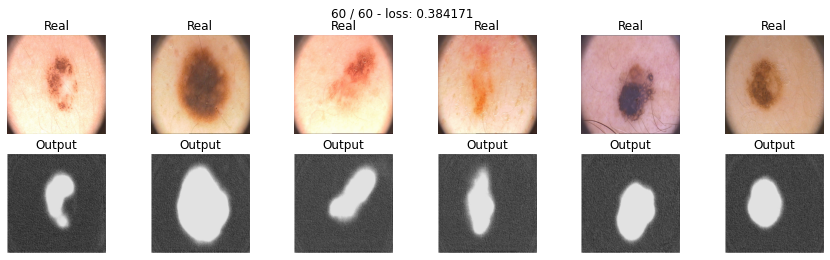

In [ ]:
max_epochs = 60
optim = torch.optim.AdamW(model.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
model, history = train(model, optim, lr_sch, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model, iou_pytorch, data_val)

0.6740000247955322

In [ ]:
loss1, acc1, val_loss1, val_acc1 = zip(*history)

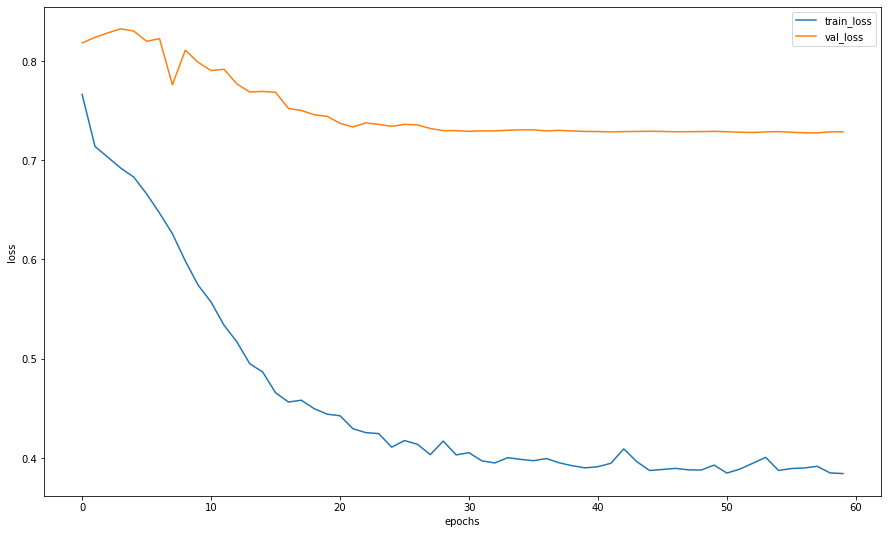

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss1, label="train_loss")
plt.plot(val_loss1, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

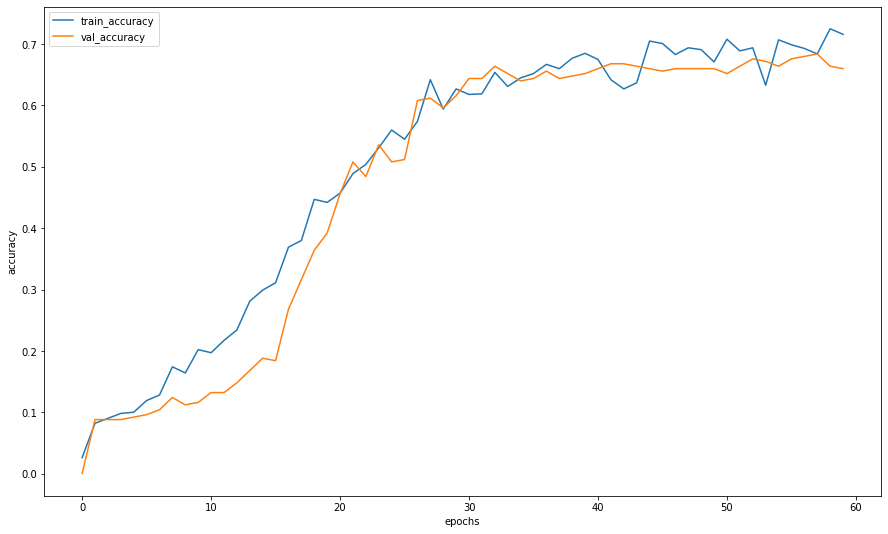

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc1, label="train_accuracy")
plt.plot(val_acc1, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### SegNet + dice_loss

In [ ]:
def dice_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    num = (2*y_real*y_pred).sum()
    den =  (y_real + y_pred).sum()
    res = 1 - (num+1)/(den+1)
    return res 

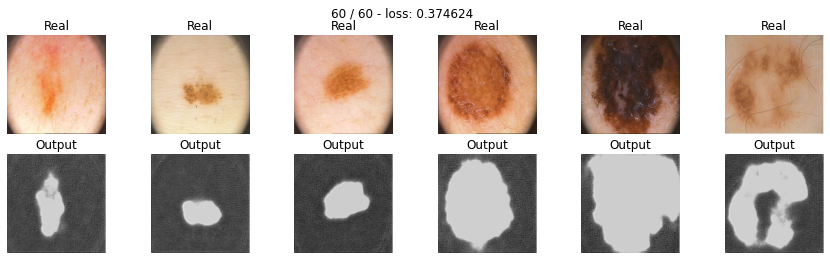

In [ ]:
model_dice = SegNet().to(device)

max_epochs = 60
optim = torch.optim.AdamW(model_dice.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
model_dice, history = train(model_dice, optim, lr_sch, dice_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_dice, iou_pytorch, data_val)

0.6759999990463257

In [ ]:
loss2, acc2, val_loss2, val_acc2 = zip(*history)

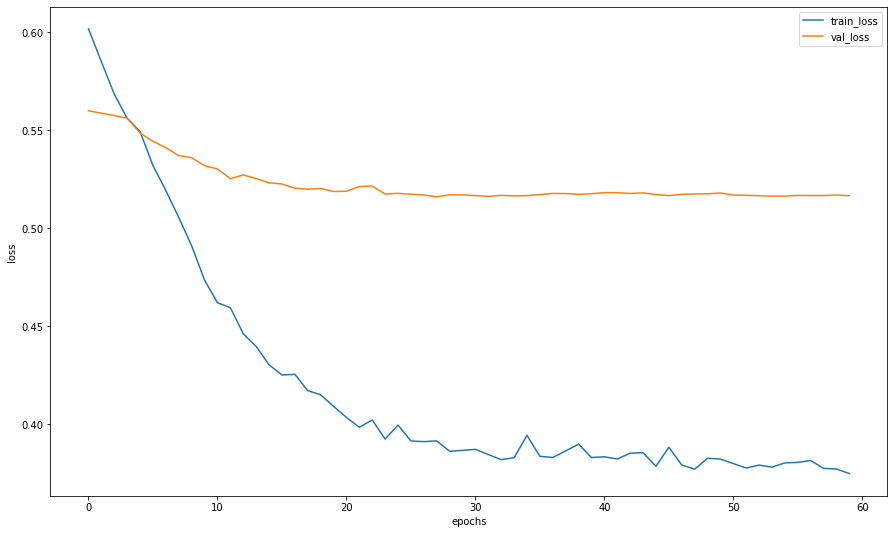

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss2, label="train_loss")
plt.plot(val_loss2, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

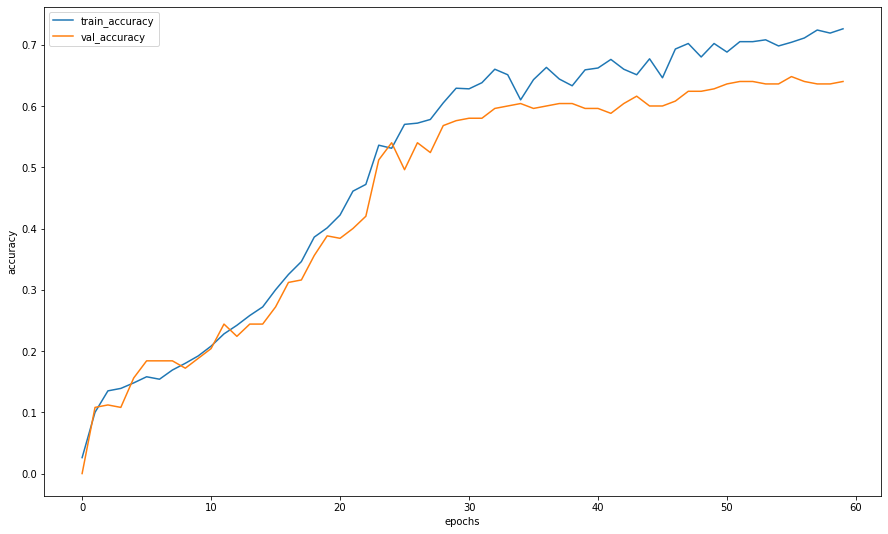

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc2, label="train_accuracy")
plt.plot(val_acc2, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### SegNet + focal_loss

**Focal loss:**

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    y_pred = torch.clamp(y_pred, min=eps, max=1-eps)
    y_pred = torch.sigmoid(y_pred)
    y_real = torch.clamp(y_real, min=eps)
    your_loss = -torch.sum(((1-y_pred)**gamma)*y_real*torch.log(y_pred) + (y_pred**gamma)*(1-y_real)*torch.log(1-y_pred))

    return your_loss

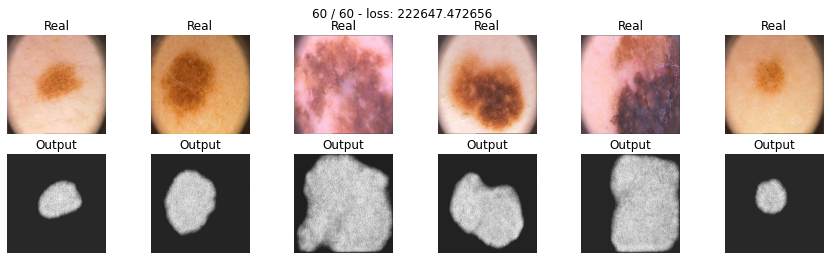

In [ ]:
model_focal = SegNet().to(device)

max_epochs = 60
optim = torch.optim.AdamW(model_focal.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
model_focal, history = train(model_focal, optim, lr_sch, focal_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_focal, iou_pytorch, data_val)

0.7039999961853027

In [ ]:
loss3, acc3, val_loss3, val_acc3 = zip(*history)

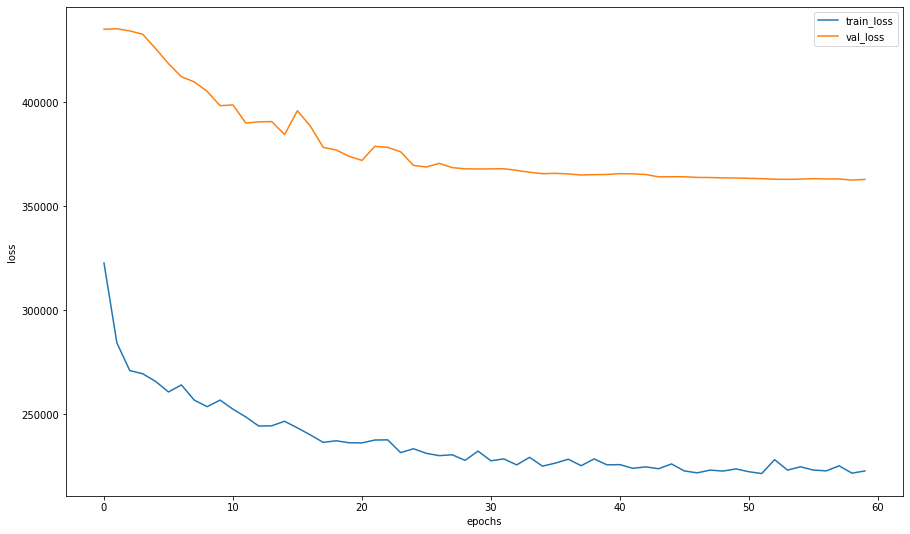

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss3, label="train_loss")
plt.plot(val_loss3, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

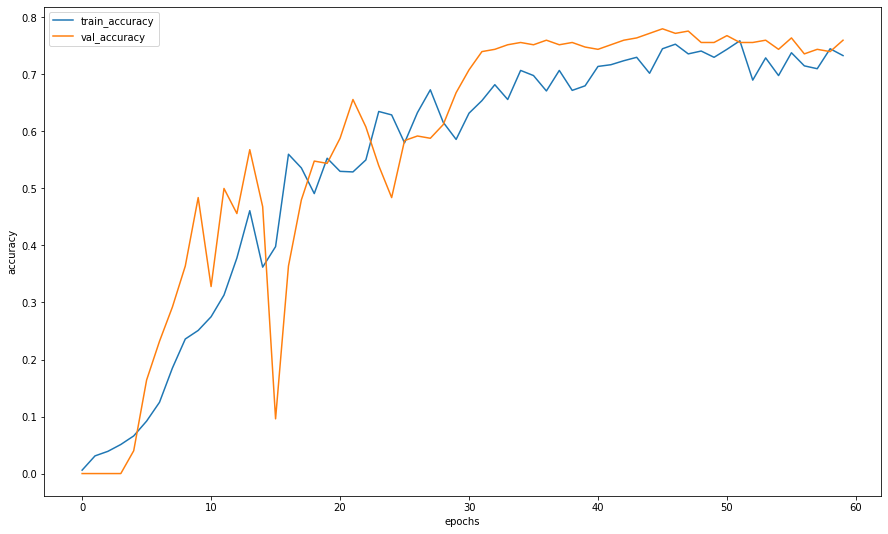

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc3, label="train_accuracy")
plt.plot(val_acc3, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

### SegNet + SSIM_loss

In [ ]:
def SSIM_loss(y_real, y_pred, alpha=0.1, betta=0.2, gamma=0.3):
    y_real = y_real.to('cpu')
    y_pred = y_pred.to('cpu')

    y_pred = torch.sigmoid(y_pred)

    mu_pred = y_pred.sum(2).sum(2).reshape(-1)
    mu_real = y_real.sum(2).sum(2).reshape(-1)

    sig_pred = torch.var(y_pred, dim=(2,3)).reshape(-1)
    sig_real = torch.var(y_real, dim=(2,3)).reshape(-1)
    sig_real_pred = torch.var(y_real*y_pred, dim=(2,3)).reshape(-1)
    sig_pred = torch.sqrt(sig_pred)
    sig_real = torch.sqrt(sig_real)
    sig_real_pred = torch.sqrt(sig_real_pred)

    l = (2*mu_pred*mu_real+1)/(mu_pred**2+mu_real**2+1)
    c = (2*sig_pred*sig_real+1)/(sig_pred**2+sig_real**2+1)
    s = (sig_real_pred+1)/(sig_pred*sig_real+1)

    loss = (l**alpha)*(c**betta)*(s**gamma)
    return torch.mean(1-loss)

In [ ]:
model_SSIM = SegNet().to(device)

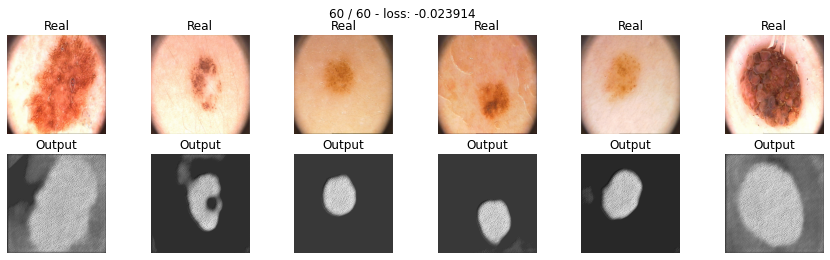

In [ ]:
max_epochs = 60
optim = torch.optim.AdamW(model_SSIM.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
model_SSIM, history = train(model_SSIM, optim, lr_sch, SSIM_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(model_SSIM, iou_pytorch, data_val)

0.5679999589920044

In [ ]:
loss4, acc4, val_loss4, val_acc4 = zip(*history)

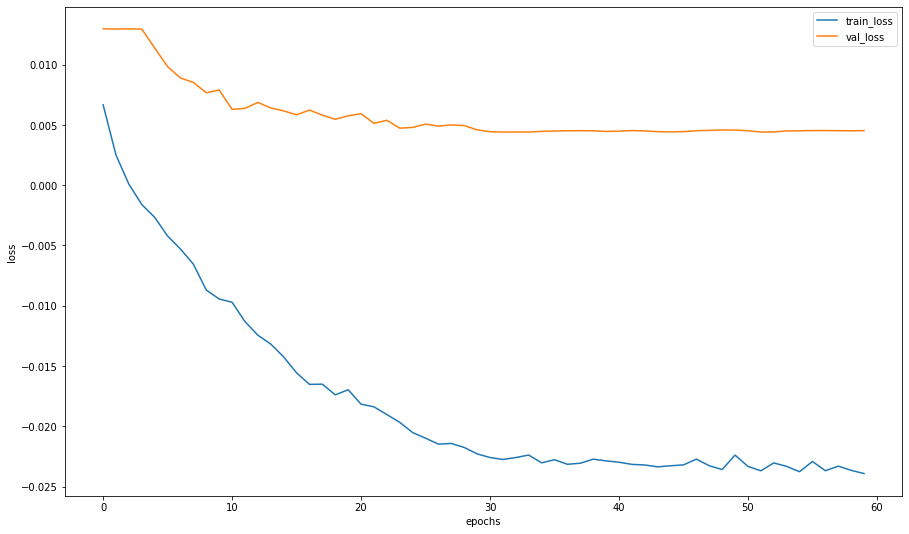

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss4, label="train_loss")
plt.plot(val_loss4, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

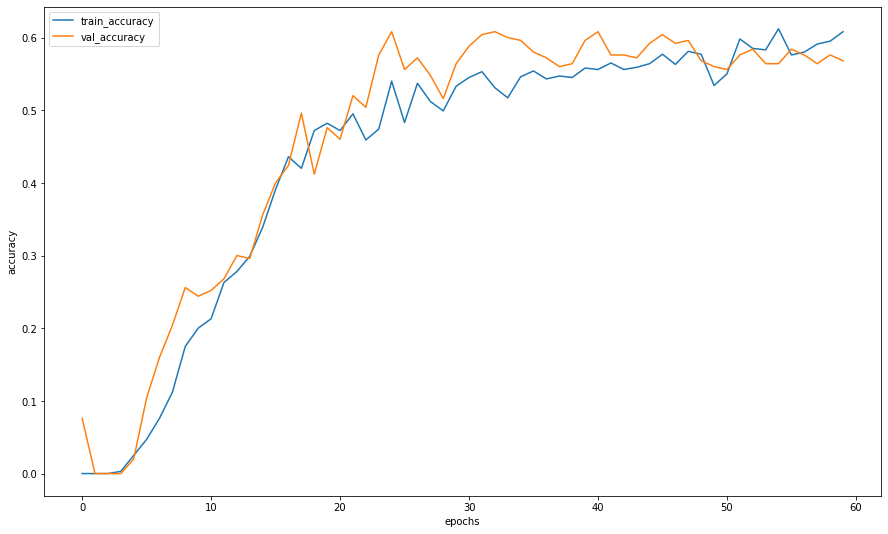

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc4, label="train_accuracy")
plt.plot(val_acc4, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()


# U-Net


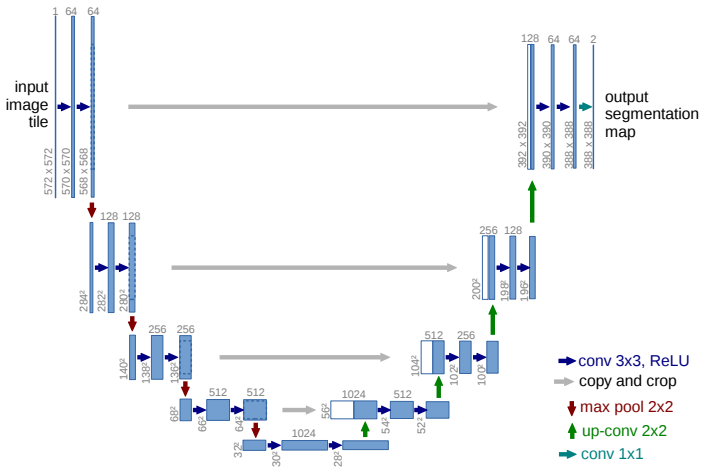

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.MaxUnpool2d(kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):

        # encoder
        x = self.enc_conv0(x)
        p0, indices_0 = self.pool0(x)
        e0 = self.enc_conv1(p0)
        p1, indices_1 = self.pool1(e0) 
        e1 = self.enc_conv2(p1)
        p2, indices_2 = self.pool2(e1)
        e2 = self.enc_conv3(p2)
        p3, indices_3 = self.pool3(e2)
        e3 = self.bottleneck_conv1(p3)

        # bottleneck
        b1, indices_4 = self.pool4(e3)
        b2 = self.bottleneck_conv2(self.unpool(b1, indices_4))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b2+p3, indices_3))
        d1 = self.dec_conv1(self.upsample1(d0+p2, indices_2))
        d2 = self.dec_conv2(self.upsample2(d1+p1, indices_1))
        d3 =  self.dec_conv3(self.upsample3(d2+p0, indices_0))
        
        return d3

### UNet + bce_loss

In [ ]:
unet_model = UNet().to(device)

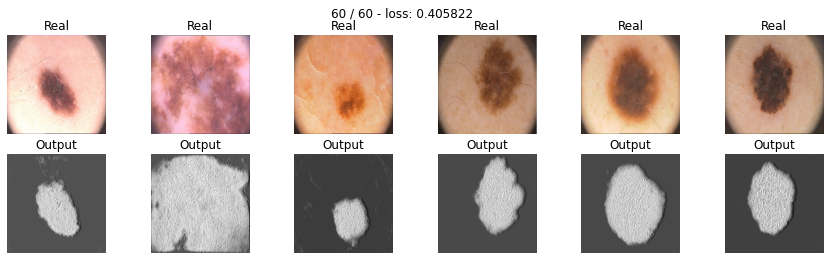

In [ ]:
max_epochs = 60
optim = torch.optim.AdamW(unet_model.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
unet_model, history = train(unet_model, optim, lr_sch, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

0.6919999718666077

In [ ]:
loss5, acc5, val_loss5, val_acc5 = zip(*history)

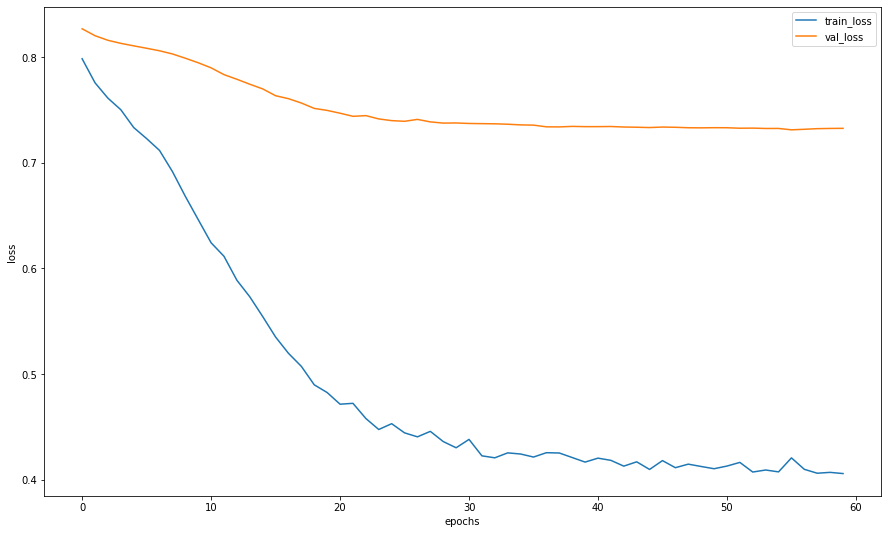

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss5, label="train_loss")
plt.plot(val_loss5, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

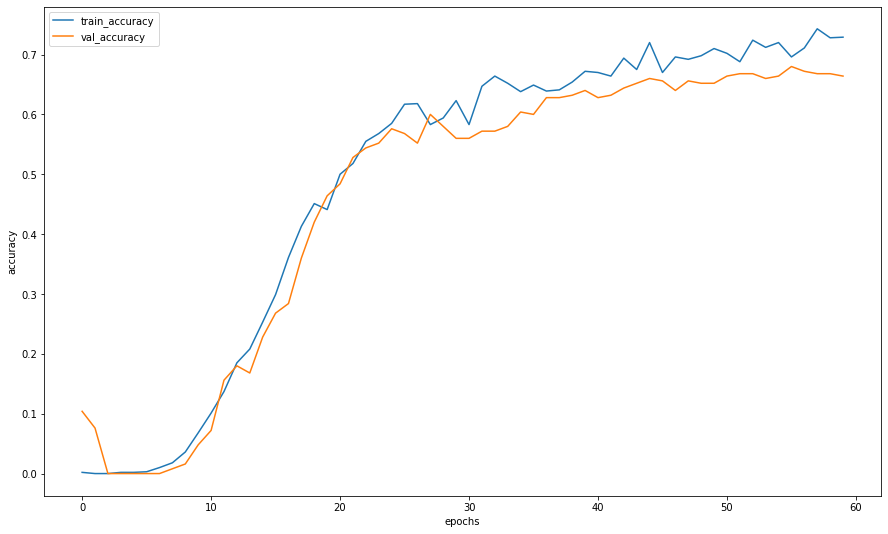

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc5, label="train_accuracy")
plt.plot(val_acc5, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

In [ ]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 256 -> 128

        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64

        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32

        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        self.pool4 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        self.unpool = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)

        self.bottleneck_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 16 -> 32

        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64

        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )

        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 128

        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )

        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256

        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1),
            nn.ReLU(),
            nn.Conv2d(in_channels=1, out_channels=1, kernel_size=3, padding=1),
            nn.BatchNorm2d(1)
        )

    def forward(self, x):

        # encoder
        x = self.enc_conv0(x)
        p0 = self.pool0(x)
        e0 = self.enc_conv1(p0)
        p1 = self.pool1(e0) 
        e1 = self.enc_conv2(p1)
        p2 = self.pool2(e1)
        e2 = self.enc_conv3(p2)
        p3 = self.pool3(e2)
        e3 = self.bottleneck_conv1(p3)

        # bottleneck
        b1 = self.pool4(e3)
        b2 = self.bottleneck_conv2(self.unpool(b1))

        # decoder
        d0 = self.dec_conv0(self.upsample0(b2+p3))
        d1 = self.dec_conv1(self.upsample1(d0+p2))
        d2 = self.dec_conv2(self.upsample2(d1+p1))
        d3 =  self.dec_conv3(self.upsample3(d2+p0))
        
        return d3

### UNet_2 + bce_loss

In [ ]:
unet2_model = UNet2().to(device)

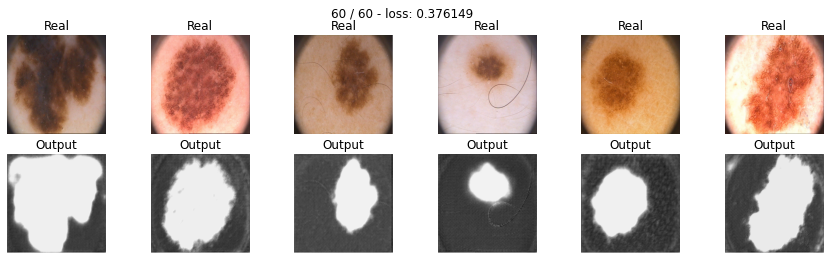

In [ ]:
max_epochs = 60
optim = torch.optim.AdamW(unet2_model.parameters(), lr=1e-4)
lr_sch = lr_scheduler.StepLR(optim, step_size=30, gamma=0.1)
unet2_model, history = train(unet2_model, optim, lr_sch, bce_loss, max_epochs, data_tr, data_val)

In [ ]:
score_model(unet2_model, iou_pytorch, data_val)

0.7360000610351562

In [ ]:
loss6, acc6, val_loss6, val_acc6 = zip(*history)

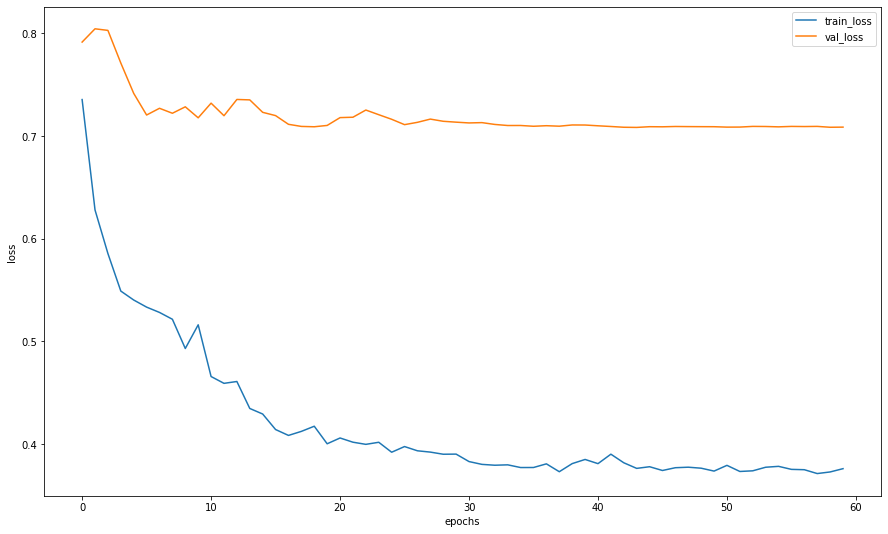

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(loss6, label="train_loss")
plt.plot(val_loss6, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

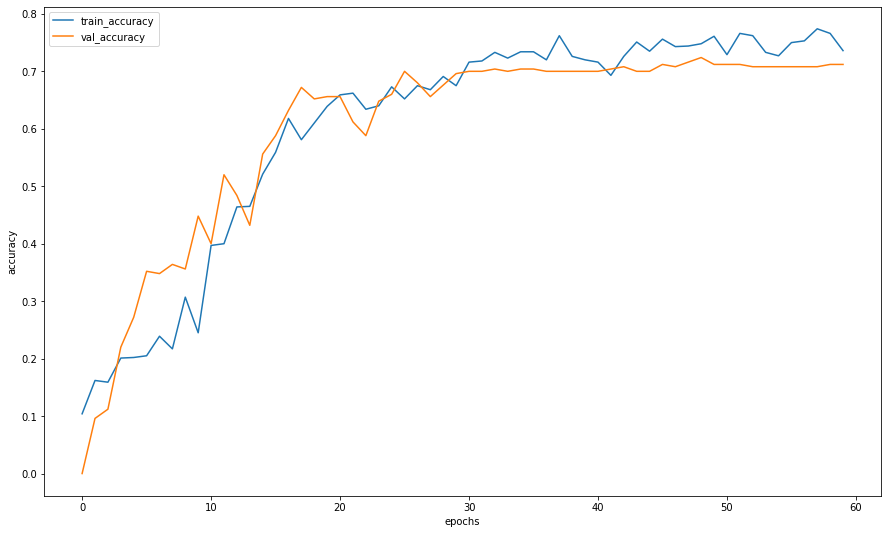

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc6, label="train_accuracy")
plt.plot(val_acc6, label="val_accuracy")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

As a result , three models were written: SigNet, UNet, UNet_2. Metric: IOU. Loss: BCE_loss, Dice_loss, Focal_loss, SSIM_loss.

Qualities that have received:

SigNet + BCE_loss = 0.674

SigNet + Dice_loss = 0.676

SigNet + Focal_loss = 0.704

SigNet + SSIM_loss = 0.568

UNet + BCE_loss = 0.692

UNet_2 + BCE_loss = 0.736

I got the best quality by using UNet_2 + BCE_loss

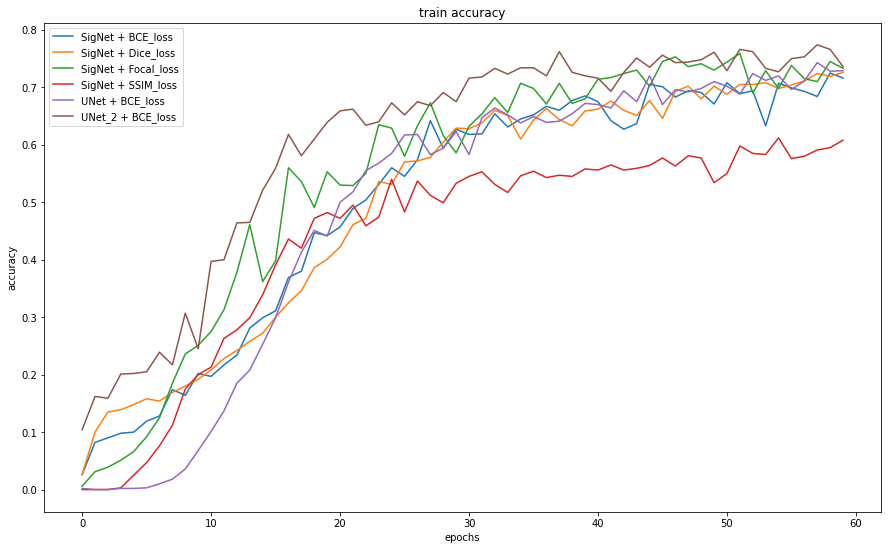

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(acc1, label="SigNet + BCE_loss")
plt.plot(acc2, label="SigNet + Dice_loss")
plt.plot(acc3, label="SigNet + Focal_loss")
plt.plot(acc4, label="SigNet + SSIM_loss")
plt.plot(acc5, label="UNet + BCE_loss")
plt.plot(acc6, label="UNet_2 + BCE_loss")
plt.legend(loc='best')
plt.title("train accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()

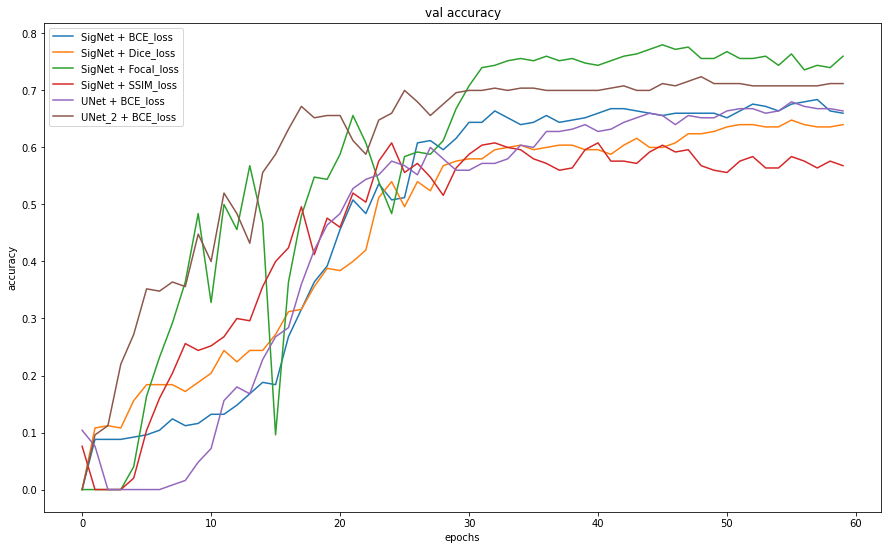

In [ ]:
plt.figure(figsize=(15, 9))
plt.plot(val_acc1, label="SigNet + BCE_loss")
plt.plot(val_acc2, label="SigNet + Dice_loss")
plt.plot(val_acc3, label="SigNet + Focal_loss")
plt.plot(val_acc4, label="SigNet + SSIM_loss")
plt.plot(val_acc5, label="UNet + BCE_loss")
plt.plot(val_acc6, label="UNet_2 + BCE_loss")
plt.legend(loc='best')
plt.title("val accuracy")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.show()